In [0]:
import numpy as np
import tensorflow as tf
import os
import gym
import scipy.signal # for cumulative returns
from numpy.linalg import inv # for conjugate gradient
import time
import matplotlib.pyplot as plt

In [0]:
# PARAMETERS

env = gym.make('Pendulum-v0')
state_size = env.observation_space.shape
action_size = env.action_space.shape

total_episodes = 30
gamma = 0.99
max_path_len = 250
total_steps = 5000
cg_damping = 0.1
max_kl = 0.01

In [3]:
# FUNCTIONS


def gauss_log_prob(x, mu, logstd):
    var = tf.math.exp(2 * logstd)
    prob = -tf.math.square(x - mu) / (2 * var) - 0.5 * tf.math.log(tf.constant(2 * np.pi)) - logstd
    return tf.math.reduce_sum(prob, axis=1)


def gauss_kl(mu1, logstd1, mu2, logstd2):
    var1 = tf.math.exp(2 * logstd1)
    var2 = tf.math.exp(2 * logstd2)
    kl = tf.math.reduce_sum(logstd2 - logstd1 + (var1 + tf.math.square(mu1 - mu2)) / (2 * var2 + 1e-8) - 0.5)
    return kl


def gauss_entropy(mu, logstd):
    return tf.math.reduce_sum(logstd + 0.5 * tf.constant(2 * np.pi * np.e, dtype = tf.float32))


def var_shape(x):
    return [k.value for k in x.get_shape()]


def numel(x):
    return np.prod(var_shape(x))


def flat_grad(loss, var_list):
    grads = tf.gradients(loss, var_list)
    return tf.concat(values=[tf.reshape(grad, [numel(v)]) for (v, grad) in zip(var_list, grads)], axis=0)


def gauss_kl_firstfixed(mu, logstd):
    mu1, logstd1 = map(tf.stop_gradient, [mu, logstd])
    
    return gauss_kl(mu1, logstd1, mu, logstd)


def slice_vector(vector, shapes):
    start = 0
    tensors = []
    for shape in shapes:
        size = np.prod(shape)
        tensor = tf.reshape(vector[start:(start + size)], shape)
        tensors.append(tensor)
        start += size
    return tensors


def get_cumulative_returns(r, gamma):
    r = np.array(r)
    return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]


class DistributionInit:
    def __init__(self, filter_mean=True):
        self.m1 = 0
        self.v = 0
        self.n = 0.
        self.filter_mean = filter_mean

    def __call__(self, o):
        self.m1 = self.m1 * (self.n / (self.n + 1)) + o    * 1/(1 + self.n)
        self.v = self.v * (self.n / (self.n + 1)) + (o - self.m1)**2 * 1/(1 + self.n)
        self.std = (self.v + 1e-6)**.5 # std
        self.n += 1
        if self.filter_mean: 
            o1 =  (o - self.m1)/self.std
        else:
            o1 =  o/self.std
        o1 = (o1 > 10) * 10 + (o1 < -10)* (-10) + (o1 < 10) * (o1 > -10) * o1 
        return o1


dist_init = DistributionInit()


def rollout(env, agent, max_path_len, total_steps, gamma):
    steps_count = 0
    paths = []
    
    while steps_count < total_steps:
        observations, actions, rewards, action_dists_mu, action_dists_logstd = [], [], [], [], []
        observation = dist_init(env.reset())
        
        for i in range(max_path_len):
            steps_count += 1
            
            observations.append(observation)
            
            action, policy = agent.act(observation)
            
            actions.append(action)
            action_dists_mu.append(policy.get('action_dist_mu', []))
            action_dists_logstd.append(policy.get('action_dist_logstd', []))
            
            observation, reward, done, _ = env.step(action)
            
            observation = dist_init(observation)
            rewards.append(reward)
            
            # print(observation, policy.get('action_dist_mu', []), policy.get('action_dist_logstd', []), reward, action)
            
            if done or steps_count == total_steps or i == max_path_len - 1:
                path = {'observations' : np.array(observations),
                        'action_dists_mu' : np.concatenate(action_dists_mu),
                        'action_dists_logstd' : np.concatenate(action_dists_logstd),
                        'rewards' : np.array(rewards),
                        'actions' :  np.array(actions), 
                        'cumulative_returns' : get_cumulative_returns(rewards, gamma)
                       }
                paths.append(path)
                break
   
    return paths


class FlatWeights:
    def __init__(self, sess, var_list):
        self.sess = sess
        self.flat = tf.concat([tf.reshape(v, shape=[numel(v)]) for v in var_list], axis=0)
        
    def __call__(self):
        return self.flat.eval(session=self.sess)


class LoadFlatWeights:
    def __init__(self, sess, var_list):
        self.sess = sess
        assigns = []
        shapes = map(var_shape, var_list)
        total_size = sum(np.prod(shape) for shape in shapes)
        self.theta = tf.placeholder(dtype=tf.float32, shape=total_size)
        
        start = 0
        for (shape, v) in zip(shapes, var_list):
            size = np.prod(shape)
            assigns.append(tf.assign(v, tf.reshape(self.theta[start:start + size], shape)))
            start += size
        
        self.op = tf.group(*assigns)
        
    
    def __call__(self, theta):
        self.sess.run(self.op, feed_dict={self.theta : theta})

    
def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    p = b.copy()
    r = b.copy()
    x = np.zeros_like(b)
    rdotr = r.dot(r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (p.dot(z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = r.dot(r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x



# TODO: FIX LINESEARCH


def linesearch(f, x, full_step, max_kl):
    max_backtracks = 10
    loss, _, _ = f(x)
    
    for step_frac in (0.5)**np.arange(max_backtracks):
        new_x = x + step_frac * full_step
        new_loss, kl, _ = f(new_x)
        actual_improve = loss - new_loss
        '''
        print('kl', kl)
        print('x', x)
        print('x_new', x_new)
        print('loss', loss)
        print('new_loss', new_loss)
        '''
        if kl <= max_kl and actual_improve > 0:
            x = new_x
            loss = new_loss
    return x


'''
def linesearch(f, x, full_step, expected_improve_ratio):
    max_backtracks = 10
    accept_ratio = 0.1
    loss, _, _ = f(x)
    
    for step_frac in (0.5)**(np.arange(max_backtracks)):
        new_x = x + step_frac * full_step
        new_loss, _, _ = f(new_x)
        actual_improve = loss - new_loss
        expected_improve = expected_improve_ratio * step_frac
        ratio = actual_improve / expected_improve
        
        print()
        print('new step in linesearch:', step_frac)
        print('ratio', ratio)
        print('accept_ratio', accept_ratio)
        print('actual_improve', actual_improve)
        print('x', x)
        print('new_x', new_x)
        print('loss', loss)
        print('new_loss', new_loss)
        print()
        
        if ratio > accept_ratio and actual_improve > 0:
            x = new_x
            loss = new_loss
        
    return x
'''

"\ndef linesearch(f, x, full_step, expected_improve_ratio):\n    max_backtracks = 10\n    accept_ratio = 0.1\n    loss, _, _ = f(x)\n    \n    for step_frac in (0.5)**(np.arange(max_backtracks)):\n        new_x = x + step_frac * full_step\n        new_loss, _, _ = f(new_x)\n        actual_improve = loss - new_loss\n        expected_improve = expected_improve_ratio * step_frac\n        ratio = actual_improve / expected_improve\n        \n        print()\n        print('new step in linesearch:', step_frac)\n        print('ratio', ratio)\n        print('accept_ratio', accept_ratio)\n        print('actual_improve', actual_improve)\n        print('x', x)\n        print('new_x', new_x)\n        print('loss', loss)\n        print('new_loss', new_loss)\n        print()\n        \n        if ratio > accept_ratio and actual_improve > 0:\n            x = new_x\n            loss = new_loss\n        \n    return x\n"

In [0]:
class Agent:
    def __init__(self, env, state_size, action_size, total_episodes, gamma, max_path_len, total_steps, cg_damping=0.1, max_kl=0.01):
        self.env = env
        self.state_size = state_size[0]
        self.action_size = np.prod(action_size).item()
        self.sess = tf.Session()
        self.total_episodes = total_episodes
        self.gamma = gamma
        self.max_path_len = max_path_len
        self.total_steps = total_steps
        self.cg_damping = cg_damping
        self.max_kl = max_kl
        
        self.obs = tf.placeholder(dtype=tf.float32, shape=((None,) + state_size), name='state')
        print(self.obs.shape)
        self.action = tf.placeholder(dtype=tf.float32, shape=((None,) + action_size), name='action')
        self.advantage = tf.placeholder(dtype=tf.float32, shape=None, name='advantage')
        
        # Gauss parameters
        self.old_action_dist_mu = tf.placeholder(dtype=tf.float32, shape=((None,) + action_size))
        self.old_action_dist_logstd = tf.placeholder(dtype=tf.float32, shape=((None,) + action_size))
        
        # Neural network
        self.first_layer = tf.contrib.layers.fully_connected(inputs=self.obs, num_outputs=64, scope='first_layer')
        self.second_layer = tf.contrib.layers.fully_connected(inputs=self.first_layer, num_outputs=64, scope='second_layer')
        self.output = tf.contrib.layers.fully_connected(inputs=self.second_layer, num_outputs=self.action_size, scope='output')
        # output = action_dist_mu
        
        self.action_dist_logstd_param = tf.Variable((0.01 * np.random.randn(1, self.action_size)).astype(np.float32), name='action_dist_logsd_param')
        self.action_dist_logstd = tf.tile(self.action_dist_logstd_param, tf.stack((tf.shape(self.output)[0], 1)))
        
        log_prob = gauss_log_prob(self.action, self.output, self.action_dist_logstd)
        log_prob_old = gauss_log_prob(self.action, self.old_action_dist_mu, self.old_action_dist_logstd)
        
        # L_surr = -E[ prob / prob_old * advantage ]
        frac = tf.exp(log_prob - log_prob_old)
        L_surr = -tf.math.reduce_mean(frac * self.advantage)
        
        var_list = tf.trainable_variables()
        
        batch_size = tf.cast(tf.shape(self.obs)[0], dtype=tf.float32)
        kl = gauss_kl(self.old_action_dist_mu, self.old_action_dist_logstd, self.output, self.action_dist_logstd) / batch_size
        entropy = gauss_entropy(self.output, self.action_dist_logstd) / batch_size
        
        self.losses = [L_surr, kl, entropy]
        
        self.flat_grad_surr = flat_grad(L_surr, var_list)
        
        kl_firstfixed = gauss_kl_firstfixed(self.output, self.action_dist_logstd) / batch_size
        grads = tf.gradients(kl_firstfixed, var_list)
        
        self.flat_tangent = tf.placeholder(dtype=tf.float32, shape=None)
        shapes = map(var_shape, var_list)
        tangents = slice_vector(self.flat_tangent, shapes)
        
        grad_vec_prod = [tf.math.reduce_sum(g * t) for (g, t) in zip(grads, tangents)]
        self.fisher_vec_prod = flat_grad(grad_vec_prod, var_list)
        
        self.flat_weights = FlatWeights(self.sess, var_list)
        self.load_flat_weights = LoadFlatWeights(self.sess, var_list)
        self.sess.run(tf.variables_initializer(var_list))
        
        
        
    def act(self, obs):
        obs = np.expand_dims(obs, axis=0)
        action_dist_mu, action_dist_logstd = self.sess.run([self.output, self.action_dist_logstd], feed_dict={self.obs : obs})
        action = action_dist_mu + np.exp(action_dist_logstd) * np.random.randn(*action_dist_logstd.shape)
        
        return_dict = {'action_dist_mu' : action_dist_mu, 'action_dist_logstd' : action_dist_logstd}
        
        return action.ravel(), return_dict
        
    def learn(self):
        episode_count = 0
        
        start_time = time.time()
        
        episode_rewards_plot = []
        
        for i in range(self.total_episodes):
            
            print ("\n********** Iteration %i ************" % i)
            
            print('Rollout')
            paths = rollout(self.env, self, self.max_path_len, self.total_steps, self.gamma)
            print('Made rollout')
            
            # Compute advantage
            for path in paths:
                path['advantages'] = path['cumulative_returns']
            
            # Updating policy
            observations = np.concatenate([path['observations'] for path in paths])
            actions = np.concatenate([path['actions'] for path in paths])
            action_dist_mu = np.concatenate([path['action_dists_mu'] for path in paths])
            action_dist_logstd = np.concatenate([path['action_dists_logstd'] for path in paths])
            
            # Normalizing advantages
            advantages = np.concatenate([path['advantages'] for path in paths])
            advantages -= advantages.mean()
            advantages /= (advantages.std() + 1e-8)
            
            ############################################################################### TEST PRINT
            #print('Obs           ', 'size         ', len(observations), *observations)
            #print('Actions       ', 'size         ', len(actions), *actions)
            #print('Advantages    ', 'size         ', len(advantages), *advantages)
            #print('Mu            ', 'size         ', len(action_dist_mu), *action_dist_mu)
            #print('Logstd        ', 'size         ', len(action_dist_logstd), *action_dist_logstd)
            #print()
            
            feed_dict = {self.obs : observations, 
                            self.action : actions,
                            self.advantage : advantages, 
                            self.old_action_dist_mu : action_dist_mu, 
                            self.old_action_dist_logstd : action_dist_logstd
                        }
            
            prev_theta = self.flat_weights()
            
            def fisher_vector_product(p):
                feed_dict[self.flat_tangent] = p
                return self.sess.run(self.fisher_vec_prod, feed_dict=feed_dict) + p * cg_damping
            
            flat_grad = self.sess.run(self.flat_grad_surr, feed_dict=feed_dict)
            
            step_dir = conjugate_gradient(fisher_vector_product, -flat_grad)
            
            shs = (0.5 * step_dir.dot(fisher_vector_product(step_dir)))
            
            lm = np.sqrt(shs / self.max_kl)
            
            full_step = step_dir / lm
            
            def loss(theta):
                self.load_flat_weights(theta)
                return self.sess.run(self.losses, feed_dict=feed_dict)
            
            new_theta = linesearch(loss, prev_theta, full_step, -flat_grad.dot(step_dir) / lm)
            #print('first new_theta', new_theta)
            # new_theta = prev_theta + full_step
            
            ############################################################################### TEST PRINT
            #print('prev_theta', prev_theta.shape, prev_theta)
            #print('step_dir', step_dir.shape, step_dir)
            #print('shs', shs)
            #print('lm', lm)
            #print('full_step', full_step.shape, full_step)
            #print('new_theta', new_theta.shape, new_theta)
            
            self.load_flat_weights(new_theta)
            
            # Report progress
            L_surr, kl, entropy = self.sess.run(self.losses, feed_dict=feed_dict)
            episode_rewards = np.array([path['rewards'] for path in paths])
            episode_count += len(episode_rewards)
            episode_rewards_plot.append(episode_rewards.mean())
            
            stats = {}
            stats['Total number of episodes'] = episode_count
            stats['Average sum of rewards per episode'] = episode_rewards.mean()
            stats["Std of rewards per episode"] = episode_rewards.std()
            stats['Entropy'] = entropy
            stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
            stats['KL between old and new distribution'] = kl
            stats['Surrogate loss'] = L_surr
            for k, v in stats.items():
                print(k + ': ' + ' ' * (40 - len(k)) + str(v))
            
            if entropy != entropy:
                exit(-1)
        
        
        plt.plot(np.arange(1, len(episode_rewards_plot) + 1), episode_rewards_plot)
        plt.ylabel('Mean of trajectories')
        plt.xlabel('Iteration')
        plt.show()
            

(?, 3)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.

********** Iteration 0 ************
Rollout
Made rollout
Total number of episodes:                 25
Average sum of rewards per episode:       -6.357184689585136
Std of rewards per episode:               3.538162710653582
Entropy:                                  8.541175
Time elapsed:                             0.11 mins
KL between old and new distribution:      0.0
Surrogate loss:                           6.866455e-09

********** Iteration 1 ************
Rollout
Made rollout
Total number of episodes:                 50
Average sum of rewards per episode:       -5.6922645692284455
Std of rewards per episode:               3.

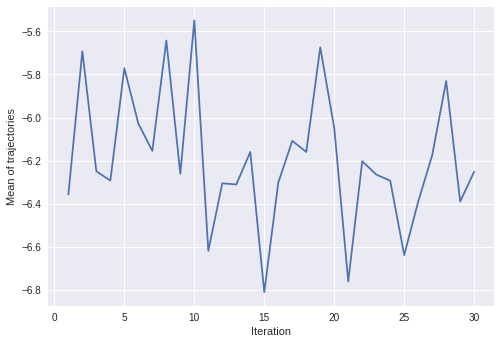

In [5]:
tf.reset_default_graph()
agent = Agent(env, state_size, action_size, total_episodes, gamma, max_path_len, total_steps, cg_damping, max_kl)
agent.learn()